# Data ingestion, processing and algorithm evaluation
## Contents
[1. Data exploration, visulation and preperation](#S1)

[2. Evaluating the algorithms](#S2)
* [2.1 Linear regression](#S21)
* [2.2 Regression forest](#S22)
* [2.3 Gaussian process](#S23)
* [2.4 Weighted K-means](#S24)

[3. Results summary](#S3)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import random
from matplotlib.lines import Line2D
import concurrent.futures
import time

<a id='S1'></a>
# 1. Data exploration, visulation and preperation 

In [2]:
raw_data = pd.read_csv('maize_major_yield.csv')

# Check for missing values...
if sum(raw_data.isnull().sum()) == 0:
    print('No missing data.')
else:
    print('Missing values in data.')

No missing data.


In [3]:
# Check for possible outliers/invalid values...
for feature in raw_data.columns:
    print(f'Feature: {feature}')
    print(f'Mean: {raw_data[feature].mean()}')
    print(f'Std dev: {raw_data[feature].std()}')
    print(f'Min: {raw_data[feature].min()}')
    print(f'Max: {raw_data[feature].max()}')
    if raw_data[feature].max() > raw_data[feature].mean()+15*raw_data[feature].std():
        print('*Possible invalid value in series: Max very high')
    elif raw_data[feature].min() < raw_data[feature].mean()-15*raw_data[feature].std():
        print('*Possible invalid value in series: Min very low')
    print()

Feature: year
Mean: 1998.0
Std dev: 8.944412794626766
Min: 1983
Max: 2013

Feature: jan rain
Mean: 82.69002331149176
Std dev: 122.1612654428912
Min: 0.0
Max: 3476.0
*Possible invalid value in series: Max very high

Feature: jan mean min temperature
Mean: 9.031864289314472
Std dev: 12.953802720553476
Min: -41.2
Max: 32.4

Feature: jan mean max temperature
Mean: 19.652315398185817
Std dev: 13.512101298889789
Min: -23.8
Max: 40.2

Feature: feb rain
Mean: 74.05522933467826
Std dev: 97.19215769545502
Min: 0.0
Max: 1009.0

Feature: feb mean min temperature
Mean: 10.078597530241767
Std dev: 12.255712621531902
Min: -38.1
Max: 32.9

Feature: feb mean max temperature
Mean: 20.98147051411301
Std dev: 12.702396124667144
Min: -18.8
Max: 46.5

Feature: mar rain
Mean: 81.62859122984219
Std dev: 93.78961618990908
Min: 0.0
Max: 1102.4

Feature: mar mean min temperature
Mean: 12.035550025201406
Std dev: 10.3490427730365
Min: -34.4
Max: 85.2

Feature: mar mean max temperature
Mean: 23.22828881048463
Std 

In [4]:
# Remove invalid temperature data (from temperature columns)...
temp_cols = []
for i in range(len(raw_data.columns)):
    if raw_data.columns[i].find('temp') != -1:
        temp_cols.append(raw_data.columns[i])

lowest_earth_temp = -128.6 # According to World meteriological association
highest_earth_temp = 56.7  #
        
for feature in temp_cols:
    raw_data.loc[raw_data[feature] < lowest_earth_temp-50, [feature]] = np.nan
    raw_data.loc[raw_data[feature] > highest_earth_temp+50, [feature]] = np.nan

# Remove np.nan values...
raw_data = raw_data.dropna()

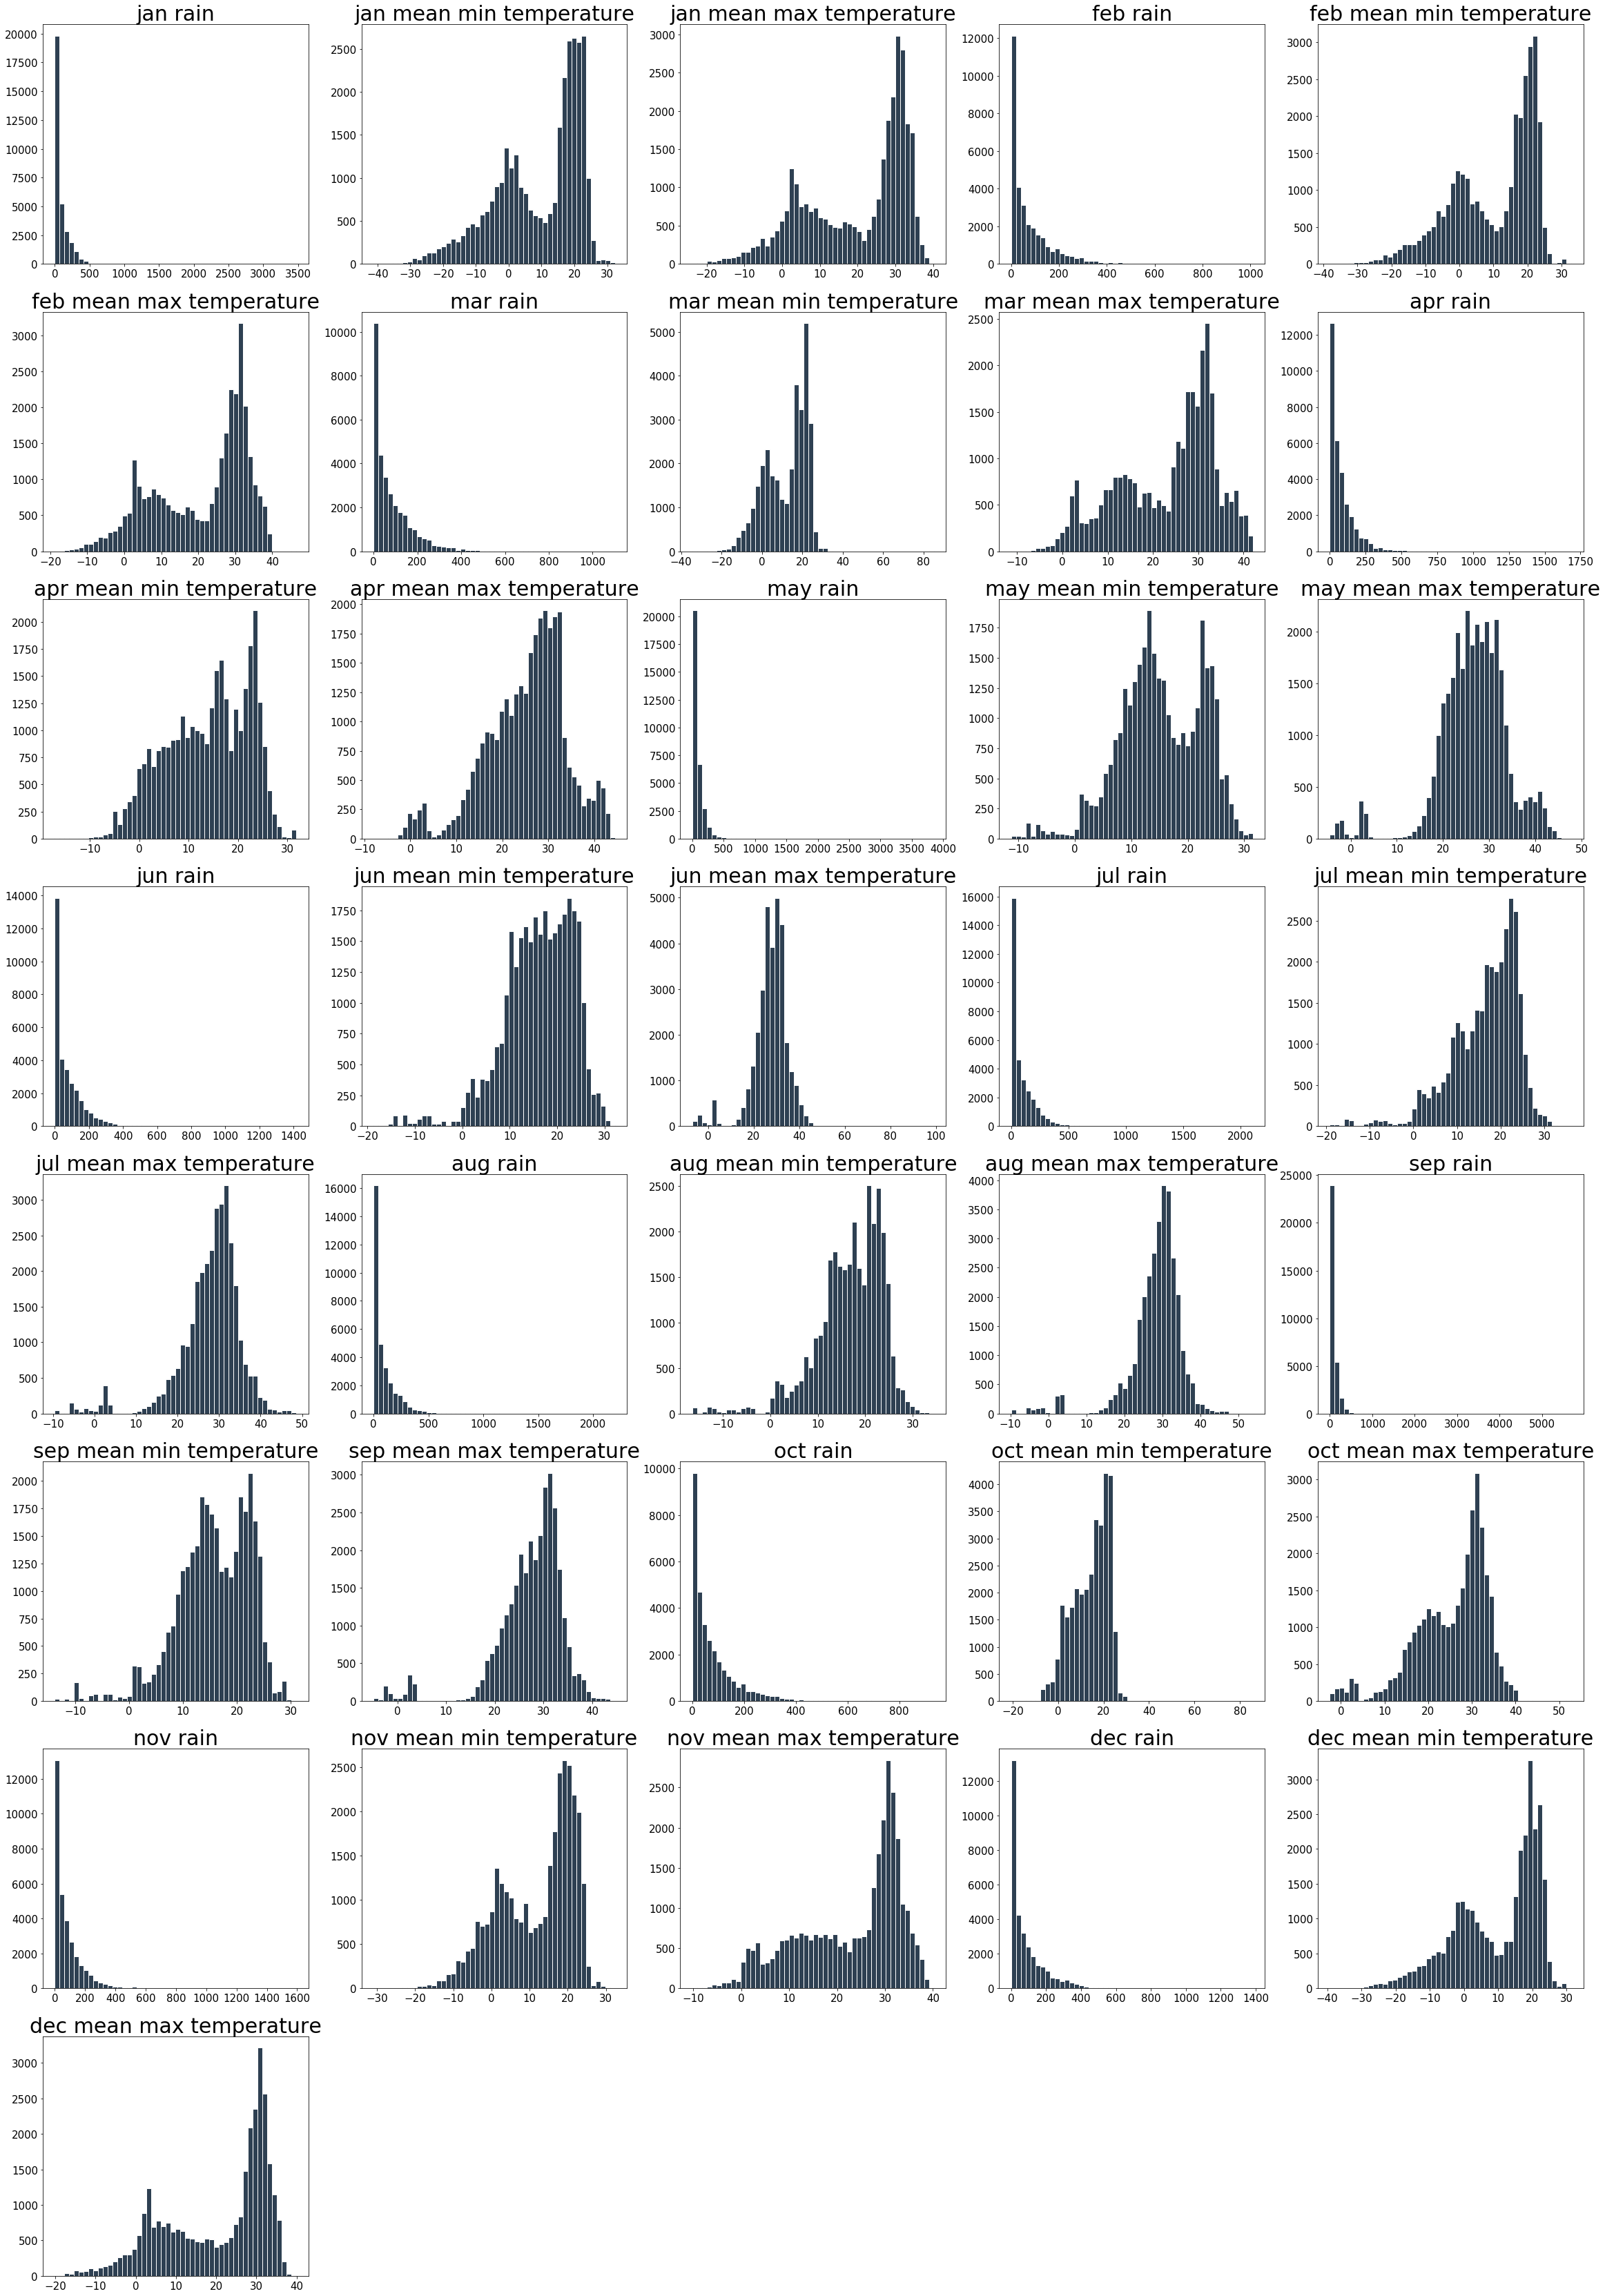

In [5]:
# Histograms to show distribtuions of data...
fig = plt.figure(figsize = (40, 60))
for i, var in enumerate(raw_data.columns[1:37]):
    ax = fig.add_subplot(8, 5, i+1)
    var_montly = plt.hist(raw_data[var], color = '#2E4052', edgecolor = 'white', bins=50);    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(var, fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

# plt.savefig('Appendix A - histograms.png')

In [6]:
# # Create example plots for report...
# fig = plt.figure(figsize = (15, 6))
# example_plots = ['apr mean max temperature', 'may mean min temperature', 'mar rain']
# for i, var in enumerate(example_plots):
#     ax = fig.add_subplot(1, 3, i+1)
#     var_montly = plt.hist(data_stdize[var], color = '#2E4052', edgecolor = 'white', bins=50);    
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_title(var)

# # plt.savefig('Figure 1 - example histograms.png')

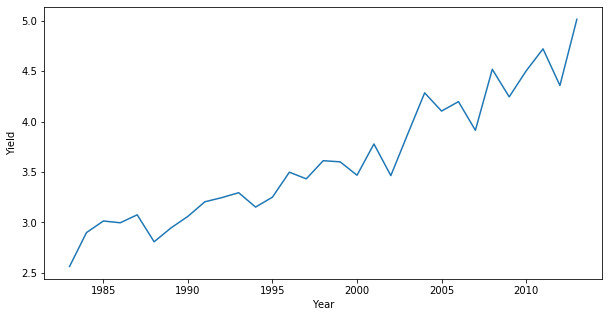

In [7]:
# Visualise the time trend...
data_yearly_avg = raw_data.groupby('year').mean()
fig = plt.figure(figsize = (10, 5))
#calibrifont = {'fontname':'Calibri'}
plt.plot(data_yearly_avg.index, data_yearly_avg['yield']);
plt.xlabel('Year');
plt.ylabel('Yield');
ax = plt.gca()
#ax.set_title('Yield time trend')
#plt.savefig('figure1 - timerend.png')

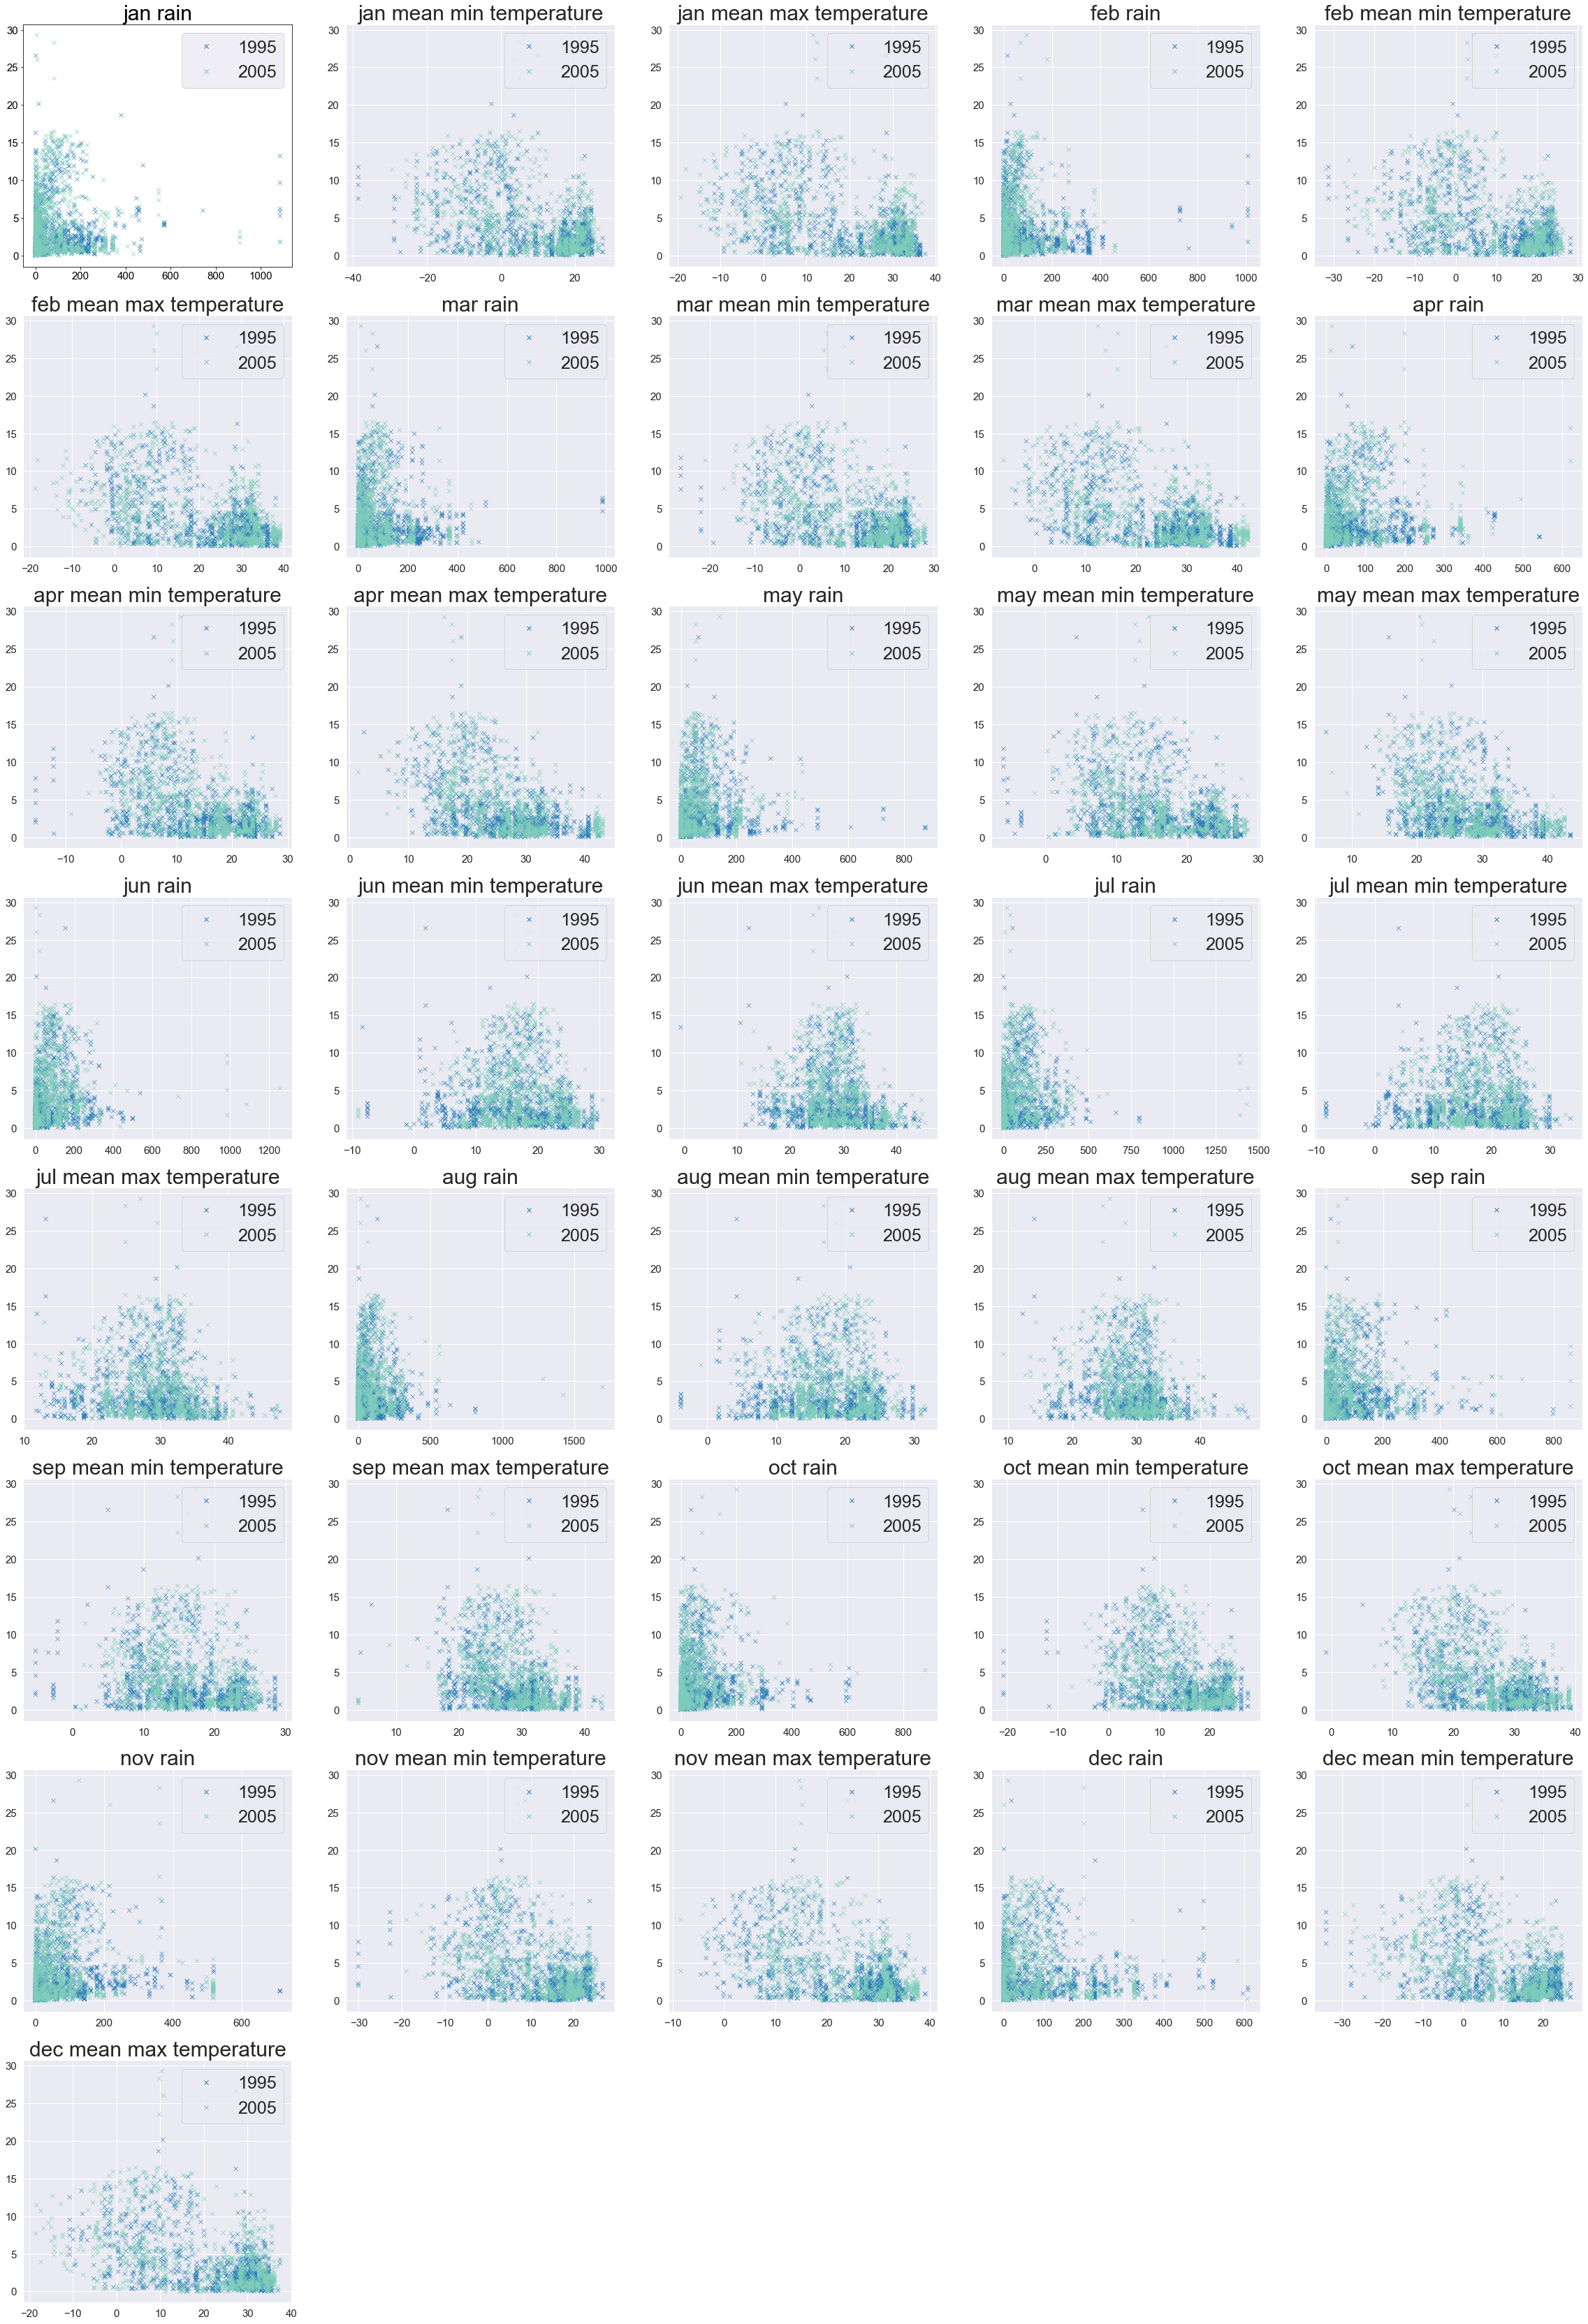

In [8]:
# Visualise relationship between features and yield before/after time trend kink...
fig = plt.figure(figsize = (40, 60))
clrs = ['#2c7fb8','#7fcdbb']
for i, var in enumerate(raw_data.columns[1:37]):
    ax = fig.add_subplot(8, 5, i+1)
    var_montly = sns.scatterplot(data=
                                 raw_data[(raw_data['year'] == 1996) | (raw_data['year'] == 2005)], 
                                 y='yield',x=var, ax=ax, hue='year',palette=clrs, marker='x', alpha=0.8);
    sns.set(font_scale=1.5);    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(var, fontsize=30)
    custom = [Line2D([], [], marker='x', color='#2c7fb8', linestyle='None'),
          Line2D([], [], marker='x', color='#7fcdbb', linestyle='None')]
    ax.legend(custom, ['1995', '2005'], loc='upper right', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.savefig('Appendix B - scatter plots.png')

In [9]:
# # Example scatter plot for report...
# fig = plt.figure(figsize = (15, 6))
# clrs = ['#2c7fb8','#7fcdbb']
# example_plots = ['apr mean max temperature', 'may mean min temperature', 'mar rain']
# for i, var in enumerate(example_plots):
#     ax = fig.add_subplot(1, 3, i+1)
#     var_montly = sns.scatterplot(data=
#                                  raw_data[(raw_data['year'] == 1996) | (raw_data['year'] == 2006)], 
#                                  y='yield',x=var, ax=ax, hue='year',palette=clrs, marker='x', alpha=0.8);
#     sns.set(font_scale=1.5);    
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_title(var)
#     custom = [Line2D([], [], marker='x', color='#2c7fb8', linestyle='None'),
#           Line2D([], [], marker='x', color='#7fcdbb', linestyle='None')]
#     ax.legend(custom, ['1996', '2006'], loc='upper right')

# plt.savefig('Figure 3 - Example scatter plots.png')

In [10]:
# Standardize features...
data_stdize = raw_data.apply(lambda x: (x-x.mean())/x.std() if x.name != 'yield' else x)

# # Normalise data...
# data_norm = raw_data.apply(lambda x: (x-x.min())/(x.max() - x.min()) if x.name != 'yield' else x)

# Split the data in to features and output variables and convert the data in to numpy arrays...
x = np.array(data_stdize.loc[:,'year':'dec mean max temperature'],dtype='float')
y = np.array(data_stdize['yield'],dtype='float')

# Test/Validation/Train split...
total_count = x.shape[0]
train_split = int(total_count * 0.7)
val_split = int(total_count * 0.85)
np.random.seed(42)
shuffle = np.random.permutation(total_count)
x_train = x[shuffle][:train_split]
y_train = y[shuffle][:train_split]
x_val = x[shuffle][train_split:val_split]
y_val = y[shuffle][train_split:val_split]
x_test = x[shuffle][val_split:]
y_test = y[shuffle][val_split:]


In [11]:
# # Split the data in to features and output variables and convert the data in to numpy arrays...
# x_train = np.array(data_stdize[raw_data['year'] < 2009].loc[:,'year':'dec mean max temperature'],dtype='float')
# y_train = np.array(data_stdize[raw_data['year'] < 2009]['yield'],dtype='float')

# x_val = np.array(data_stdize[(raw_data['year'] >= 2009) & (raw_data['year'] < 2011)].loc[:,'year':'dec mean max temperature'],dtype='float')
# y_val = np.array(data_stdize[(raw_data['year'] >= 2009) & (raw_data['year'] < 2011)]['yield'],dtype='float')

# x_test = np.array(data_stdize[raw_data['year'] >= 2011].loc[:,'year':'dec mean max temperature'],dtype='float')
# y_test = np.array(data_stdize[raw_data['year'] >= 2011]['yield'],dtype='float')

<a id='S2'></a>
# 2. Evaluating the algorithms

The algorithms and optimisers are defined in separate _.py_ files included in the folder.

In [12]:
from algorithms import linear_regression, regression_forest, fit_gaussian, k_means
from optimisers import brute_force_optimiser, GP_Optimiser

<a id='S21'></a>
### 2.1 Linear regression

In [13]:
# Linear regression...
start = time.time()
lambda_ = 0
lin_reg_result = linear_regression(x_train, y_train, x_test, y_test, lambda_)
lin_reg_rt = time.time() - start
lin_reg_R2 = 1 - (lin_reg_result['Test RMSE'] / y_test.std())**2
print(f"Linear regression without regularisation:")
print(f" Train RMSE: {lin_reg_result['Train RMSE']:.02f}")
print(f" Test RMSE: {lin_reg_result['Test RMSE']:.02f}")
print(f" Test R2: {lin_reg_R2:.02f}")

Linear regression without regularisation:
 Train RMSE: 2.98
 Test RMSE: 2.97
 Test R2: 0.35


In [14]:
# Tune lambda...
lb = [0]
ub = [100]
res = 100
start = time.time()
lin_reg_result_opt = brute_force_optimiser(linear_regression, x_train, y_train, x_val, y_val, x_test, y_test, lb, ub, res=res)
lin_reg_opt_R2 = 1 - (lin_reg_result_opt['Test RMSE'] / y_test.std())**2
lin_reg_ot = time.time() - start
print(f"Linear regression with ridge regularisation:")
print(f" Optimal validate RMSE: {lin_reg_result_opt['Val RMSE']:.02f} using lambda of {lin_reg_result_opt['Optimal HP']:.02f}")
print(f" Corresponding test RMSE: {lin_reg_result_opt['Test RMSE']:.02f}")
print(f" Test R2: {lin_reg_opt_R2:.02f}")
print(f" Optimisation took {lin_reg_ot:.02f} seconds for an R2 improvement of {lin_reg_opt_R2-lin_reg_R2:.02f} ({(lin_reg_opt_R2-lin_reg_R2)*100/lin_reg_R2:.02f}%)")

Linear regression with ridge regularisation:
 Optimal validate RMSE: 3.07 using lambda of 3.03
 Corresponding test RMSE: 2.97
 Test R2: 0.35
 Optimisation took 2.97 seconds for an R2 improvement of -0.00 (-0.01%)


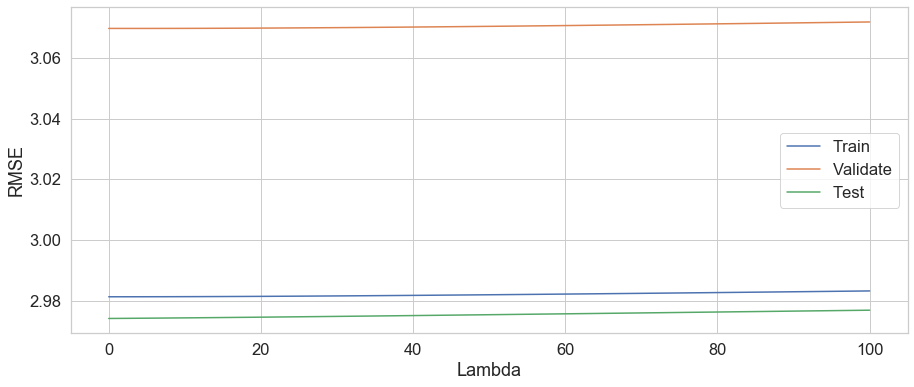

In [15]:
fig = plt.figure(figsize = (15, 6))
sns.set(style='whitegrid', font_scale=1.5)
sns.lineplot(np.linspace(lb[0],ub[0],res),lin_reg_result_opt['RMSE plot'][:,0], label="Train");
sns.lineplot(np.linspace(lb[0],ub[0],res),lin_reg_result_opt['RMSE plot'][:,1], label="Validate");
sns.lineplot(np.linspace(lb[0],ub[0],res),lin_reg_result_opt['RMSE plot'][:,2], label="Test");
plt.legend()
ax = plt.gca()
ax.set_ylabel('RMSE')
ax.set_xlabel('Lambda');
# plt.savefig('Figure 10 - BF linreg.png')

# # Plot coefs of best model...
# fig = plt.figure(figsize = (10, 5))
# ax = fig.add_subplot(1, 1, 1)
# coefs_plot = sns.barplot(x=data_stdize.loc[:,'year':'dec mean max temperature'].columns, 
#                          y=lin_reg_result_opt['coefs'][:-1],ax=ax);
# for item in coefs_plot.get_xticklabels():
#     item.set_rotation(90)
# sns.set(font_scale=1); 
# ax.set_xlabel('Feature')
# ax.set_ylabel('Coefficient')
# ax.set_title('Relative strength of each feature (excl. constant)');

<a id='S22'></a>
### 2.2 Regression forest
* Note `hps` contains the hyper parameters in the positions `[max depth, alpha, gamma]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [16]:
# Fit regression forest with arbitrary hyperparameters...
hps = [100, 10, 100]
start = time.time()
reg_forest = regression_forest(x_train, 
                               y_train, 
                               x_test, 
                               y_test, 
                               hps, 
                               kwargs={'run_concurrent': False,
                                     'no_trees': 20,
                                     'k': 1000})
reg_forest_time = time.time() - start
reg_forest_R2 = 1 - (reg_forest['Test RMSE'] / y_test.std())**2
print(f"Regression forest with arbitrary hyperparameters:")
print(f" Train RMSE: {reg_forest['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {reg_forest['OOB RMSE']:.02f}")
print(f" Test RMSE: {reg_forest['Test RMSE']:.02f}")
print(f" Test R2: {reg_forest_R2:.02f}")
print(f" Forest built in {reg_forest_time/60:.02f} mins")

Regression forest with arbitrary hyperparameters:
 Train RMSE: 3.79
 Out of bag RMSE: 2.62
 Test RMSE: 2.61
 Test R2: 0.50
 Forest built in 1.24 mins


In [17]:
# Tune max depth and alpha...
lbs = [5, 5, 80]
ubs = [15, 20, 120]
res = 16 # This controls the number of points the surrogate GP will be 
         # evaluated at to determine the optimal next step
opt_steps = 10
start = time.time()
reg_forest_opt = GP_Optimiser(regression_forest, 
                              x_train, 
                              y_train, 
                              x_val, 
                              y_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps,
                              kwargs={'run_concurrent': False,
                                     'no_trees': 20,
                                     'k': 1000})
reg_forest_ot =time.time() - start

print(f"Optimal max tree depth: {int(reg_forest_opt['Optimal Hyperparameters'][0])}, optimal alpha: {reg_forest_opt['Optimal Hyperparameters'][1]:.02f}, optimal gamma: {reg_forest_opt['Optimal Hyperparameters'][2]:.02f}")
print(f"{len(reg_forest_opt['All RMSEs'])-2} optimisation steps took {reg_forest_ot/60:.02f} mins")
print(f"Improvement over random guess: {reg_forest_opt['All RMSEs'][0][0]-reg_forest_opt['Optimal RMSE']}")

Using Bayesian optimisation...
Completed step 1 in 66.15 seconds.
Completed step 2 in 73.60 seconds.
Completed step 3 in 75.50 seconds.
Completed step 4 in 72.68 seconds.
Completed step 5 in 73.21 seconds.
Completed step 6 in 74.43 seconds.
Completed step 7 in 73.61 seconds.
Optimal max tree depth: 12, optimal alpha: 18.00, optimal gamma: 104.00
7 optimisation steps took 10.96 mins
Improvement over random guess: 0.022417432055654718


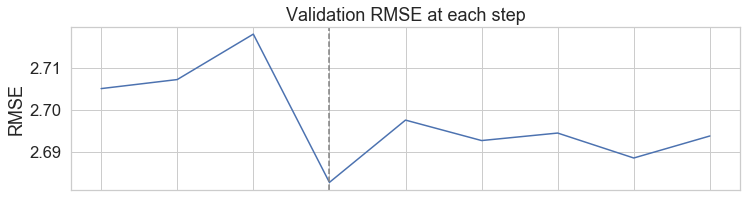

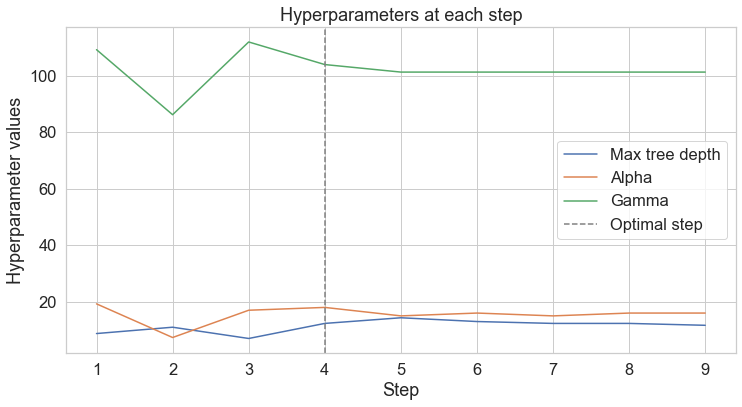

In [18]:
fig = plt.figure(figsize = (12, 3))
plt.plot(range(1,len(reg_forest_opt['All RMSEs'])+1), reg_forest_opt['All RMSEs']);
plt.title("Validation RMSE at each step")
# plt.xlabel('Step')
plt.ylabel('RMSE');
plt.xticks(np.arange(1, len(reg_forest_opt['All RMSEs'])+1, 1))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,
    labelbottom=False) 
plt.axvline(x=reg_forest_opt['Optimal step'], label="Optimal step", color='grey', linestyle='--')
# plt.savefig('Figure 12a - BO reg forest (RMSE).png')


fig = plt.figure(figsize = (12, 6))
plt.plot(range(1,len(reg_forest_opt['All HP steps'][:,0])+1), reg_forest_opt['All HP steps'][:,0], label ="Max tree depth");
plt.plot(range(1,len(reg_forest_opt['All HP steps'][:,1])+1), reg_forest_opt['All HP steps'][:,1], label ="Alpha");
plt.plot(range(1,len(reg_forest_opt['All HP steps'][:,1])+1), reg_forest_opt['All HP steps'][:,2], label ="Gamma")
plt.title("Hyperparameters at each step")
plt.xlabel('Step')
plt.ylabel('Hyperparameter values');
plt.xticks(np.arange(1, len(reg_forest_opt['All RMSEs'])+1, 1));
plt.axvline(x=reg_forest_opt['Optimal step'], label="Optimal step", color='grey', linestyle='--');
plt.legend();
# plt.savefig('Figure 12b - BO reg forest (HPs).png')

In [19]:
# Evaluate forest with optimal HPs on test data...
start = time.time()
opt_hps = reg_forest_opt['Optimal Hyperparameters']
reg_forest_opt_test = regression_forest(x_train, 
                                        y_train, 
                                        x_test, 
                                        y_test, 
                                        opt_hps, 
                                        kwargs={'k': 1000, 
                                                'no_trees': 20, 
                                                'run_concurrent': False})
reg_forest_rt = time.time()-start
opt_reg_forest_R2 = 1 - (reg_forest_opt_test['Test RMSE'] / y_test.std())**2

print(f"Regression forest with optimal hyperparameters:")
print(f" Train RMSE: {reg_forest_opt_test['Train RMSE']:.02f}")
print(f" Out of bag RMSE: {reg_forest_opt_test['OOB RMSE']:.02f}")
print(f" Test RMSE: {reg_forest_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {opt_reg_forest_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {opt_reg_forest_R2-reg_forest_R2:.02f} (+{(opt_reg_forest_R2-reg_forest_R2)*100/reg_forest_R2:.02f}%)")

Regression forest with optimal hyperparameters:
 Train RMSE: 3.78
 Out of bag RMSE: 2.60
 Test RMSE: 2.59
 Test R2: 0.51
 R2 improvement over arbitray HPs R2: 0.01 (+1.90%)


<a id='S23'></a>
### 2.3 Gaussian process

* Note `hps` contains the hyper parameters in the positions `[lengthscale, amplitude, noise variance]` and `lbs` and `ubs` contain the lower/upper bounds of the hyperparameters in this order

In [20]:
# Fit guassian with arbitrary hyperparameters
hps = [1,1,1]
gaussian_result = fit_gaussian(x_train[:12000], y_train[:12000], x_test, y_test, hps, rtn_RMSE = True)
gp_R2 = 1 - (gaussian_result['Test RMSE'] / y_test.std())**2
print(f"Gaussian process with arbitrary hyperparameters:")
print(f" Test RSME: {gaussian_result['Test RMSE']:.02f}")
print(f" Test R2: {gp_R2:.02f}")

Gaussian process with arbitrary hyperparameters:
 Test RSME: 2.38
 Test R2: 0.58


In [21]:
lbs = [1e-6,1e-6,1e-6]
ubs = [50,50,10]
opt_steps=10
res = 20 # This controls the number of points the surrogate GP will be 
         # evaluated at to determine the optimal next step
start = time.time()
gp_opt = GP_Optimiser(fit_gaussian, 
                              x_train[:12000], 
                              y_train[:12000], 
                              x_val, 
                              y_val, 
                              lbs, 
                              ubs, 
                              res = res, 
                              optimisation_steps = opt_steps,
                              check_mle=True)

gp_ot = time.time() - start
print(f"Optimal lengthscale: {gp_opt['Optimal Hyperparameters'][0]:.02f}, optimal amplitude: {gp_opt['Optimal Hyperparameters'][1]:.02f},optimal noise varaince: {gp_opt['Optimal Hyperparameters'][2]:.02f}")
print(f"{len(gp_opt['All RMSEs'])-2} optimisation steps took {gp_ot/60:.02f} mins")
print(f"Improvement over random guess: {(gp_opt['All RMSEs'][0][0]-gp_opt['Optimal RMSE'])*100/gp_opt['All RMSEs'][0][0]:0.2f}%")

Using Bayesian optimisation...
Completed step 1 in 116.77 seconds.
Completed step 2 in 111.34 seconds.
Completed step 3 in 114.05 seconds.
Completed step 4 in 113.03 seconds.
Completed step 5 in 107.63 seconds.
Completed step 6 in 109.89 seconds.
Completed step 7 in 110.05 seconds.
Completed step 8 in 110.30 seconds.
Completed step 9 in 113.61 seconds.
Completed step 10 in 116.41 seconds.
Optimal lengthscale: 5.26, optimal amplitude: 31.58,optimal noise varaince: 7.89
10 optimisation steps took 22.53 mins
Improvement over random guess: 4.81%


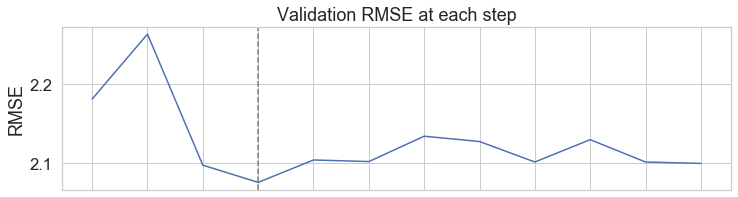

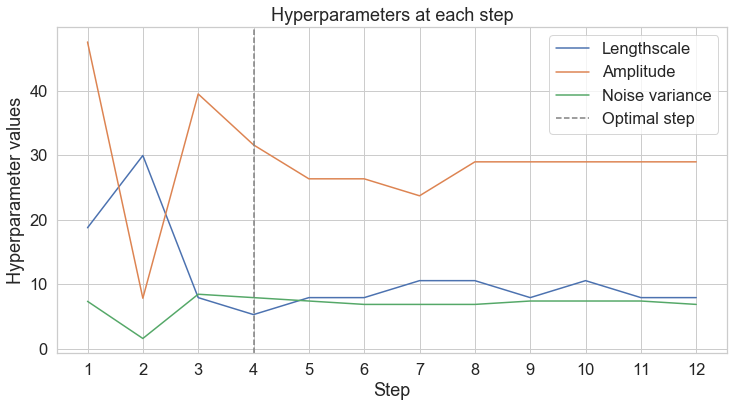

In [22]:
fig = plt.figure(figsize = (12, 3))
plt.plot(range(1,len(gp_opt['All RMSEs'])+1), gp_opt['All RMSEs']);
plt.title("Validation RMSE at each step")
# plt.xlabel('Step')
plt.xticks(np.arange(1,len(gp_opt['All RMSEs'])+1,1))
plt.ylabel('RMSE');
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,
    labelbottom=False)
plt.axvline(x=gp_opt['Optimal step'], label="Optimal step", color='grey', linestyle='--')
# plt.savefig('Figure 13a - BO GP (RMSE).png')

fig = plt.figure(figsize = (12, 6))
plt.plot(range(1,len(gp_opt['All HP steps'][:,0])+1), gp_opt['All HP steps'][:,0], label ="Lengthscale");
plt.plot(range(1,len(gp_opt['All HP steps'][:,1])+1), gp_opt['All HP steps'][:,1], label ="Amplitude");
plt.plot(range(1,len(gp_opt['All HP steps'][:,1])+1), gp_opt['All HP steps'][:,2], label ="Noise variance");
plt.title("Hyperparameters at each step")
plt.xlabel('Step')
plt.ylabel('Hyperparameter values');
plt.xticks(np.arange(1,len(gp_opt['All RMSEs'])+1,1))
plt.axvline(x=gp_opt['Optimal step'], label="Optimal step", color='grey', linestyle='--')
plt.legend();
# plt.savefig('Figure 13b - BO GP (HPs).png')

In [23]:
# Evaluate GP with optimal HPs on test data...
opt_hps = gp_opt['Optimal Hyperparameters']
start=time.time()
gp_opt_test = fit_gaussian(x_train[:12000], y_train[:12000], x_test, y_test, opt_hps, rtn_RMSE = True)
gp_rt = time.time()-start
gp_opt_test_R2 = 1 - (gp_opt_test['Test RMSE'] / y_test.std())**2
print(f"Gaussian process with optimal hyperparameters:")
print(f" Test RMSE: {gp_opt_test['Test RMSE']:.02f}")
print(f" Test R2: {gp_opt_test_R2:.02f}")
print(f" R2 improvement over arbitray HPs R2: {gp_opt_test_R2-gp_R2:.02f} (+{(gp_opt_test_R2-gp_R2)*100/gp_R2:.02f}%)")

Gaussian process with optimal hyperparameters:
 Test RMSE: 2.10
 Test R2: 0.67
 R2 improvement over arbitray HPs R2: 0.09 (+16.06%)


<a id='S24'></a>
### 2.4 Weighted K-means

In [24]:
# K-means without tuning k...
k = 20
start = time.time()
kmeans_result = k_means(x_train, y_train, x_test, y_test, k=k)
km_rt = time.time() - start
kmeans_result_R2 = 1 - (kmeans_result['Test RMSE'] / y_test.std())**2
print(f"K-means with arbitrary k:")
print(f" Train RMSE: {kmeans_result['Train RMSE']:.02f}")
print(f" Test RMSE: {kmeans_result['Test RMSE']:.02f}")
print(f" Test R2: {kmeans_result_R2:.02f}")

K-means with arbitrary k:
 Train RMSE: 2.77
 Test RMSE: 2.74
 Test R2: 0.44


In [25]:
# Tune k...
lb = [1]
ub = [100]
res = 100
start = time.time()
kmeans_opt = brute_force_optimiser(k_means, x_train, y_train, x_val, y_val, x_test, y_test, lb, ub, res=res)
kmeans_opt_R2 = 1 - (kmeans_opt['Test RMSE'] / y_test.std())**2
km_ot = time.time() - start
print(f"K-means with tuned k:")
print(f" Optimal validate RMSE: {kmeans_opt['Val RMSE']:.02f} using k of {kmeans_opt['Optimal HP']:.00f}")
print(f" Corresponding test RMSE: {kmeans_opt['Test RMSE']:.02f}")
print(f" Test R2: {kmeans_opt_R2:.02f}")
print(f" Optimisation took {km_ot/60:.02f} mins for an R2 improvement of {kmeans_opt_R2-kmeans_result_R2:.02f} (+{(kmeans_opt_R2-kmeans_result_R2)*100/kmeans_result_R2:0.2f}%)")

K-means with tuned k:
 Optimal validate RMSE: 2.66 using k of 80
 Corresponding test RMSE: 2.60
 Test R2: 0.50
 Optimisation took 8.05 mins for an R2 improvement of 0.06 (+12.45%)


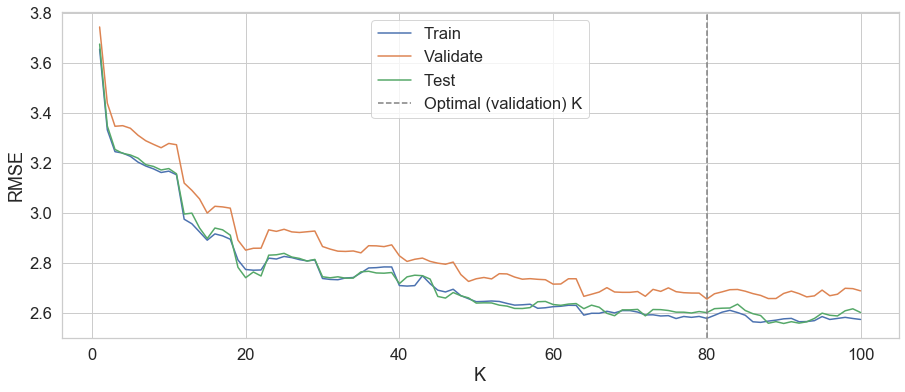

In [26]:
fig = plt.figure(figsize = (15, 6))
plt.plot(np.linspace(lb[0],ub[0],res),kmeans_opt['RMSE plot'][:,0], label="Train");
plt.plot(np.linspace(lb[0],ub[0],res),kmeans_opt['RMSE plot'][:,1], label="Validate");
plt.plot(np.linspace(lb[0],ub[0],res),kmeans_opt['RMSE plot'][:,2], label="Test");
ax = plt.gca()
ax.set_ylabel('RMSE')
ax.set_xlabel('K')
plt.axvline(x=kmeans_opt['Optimal HP'], label="Optimal (validation) K", color='grey', linestyle='--')
plt.legend();

# plt.savefig('Figure 11 - BF kmeans.png')

<a id='S3'></a>
# 3 Results summary

<a id='S31'></a>
### 3.1 Performance summary 

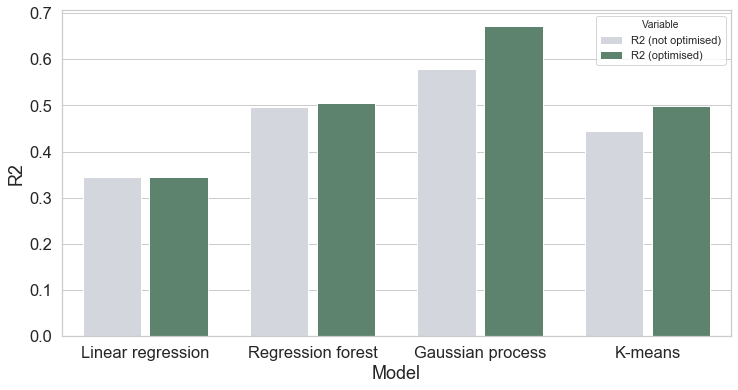

In [27]:
import matplotlib.patches as mpatches
sum_res_r2 = {'Model': ['Linear regression', 'Regression forest', 'Gaussian process', 'K-means'],
           'R2 (not optimised)': [lin_reg_R2, reg_forest_R2, 
                                    gp_R2, kmeans_result_R2],
           'R2 (optimised)': [lin_reg_opt_R2, opt_reg_forest_R2, 
                                    gp_opt_test_R2, kmeans_opt_R2] 
          }
 
sum_res_df = pd.DataFrame(data = sum_res_r2)
data = sum_res_df.melt(id_vars='Model').rename(columns=str.title)
clrs = ['#D2D5DD','#57886C']
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set(style='whitegrid')
results_plot = sns.barplot(data=data, x='Model', y='Value', hue='Variable', ax=ax1, palette=clrs);
ax1.set_ylabel('R2');
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Change the bar width...
        patch.set_width(new_value)

        # Recenter the bar....
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax1, 0.35)
#results_plot.axhline(y_test.std(), color='#000500', linestyle='dashed', label="y_test std dev");
#plt.legend(bbox_to_anchor=(1.2, 1));
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

# plt.savefig('Figure 14 - Results summary.png')

<a id='S32'></a>
### 3.2 Runtime summary 

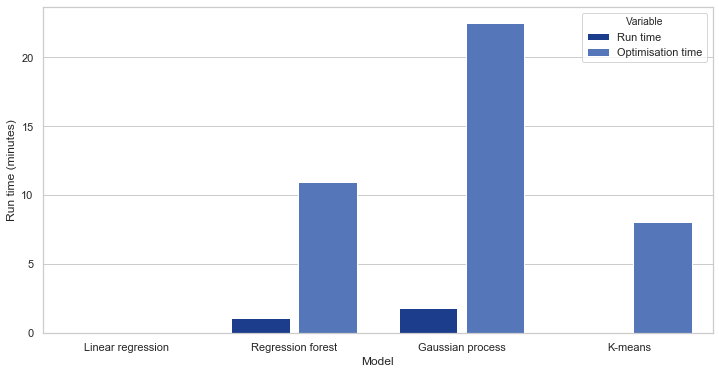

In [28]:
sum_run_times = {'Model': ['Linear regression', 'Regression forest', 'Gaussian process', 'K-means'],
           'Run time': [lin_reg_rt/60, reg_forest_rt/60, gp_rt/60, km_rt/60],
           'Optimisation time': [lin_reg_ot/60, reg_forest_ot/60,gp_ot/60, km_ot/60] 
          }

sum_run_times_df = pd.DataFrame(data = sum_run_times)
data = sum_run_times_df.melt(id_vars='Model').rename(columns=str.title)
clrs = ['#0A369D','#4472CA']
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set(style='whitegrid')
results_plot = sns.barplot(data=data, x='Model', y='Value', hue='Variable', ax=ax1, palette=clrs);
ax1.set_ylabel('Run time (minutes)');
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Change the bar width...
        patch.set_width(new_value)

        # Recenter the bar....
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax1, 0.35)

# plt.savefig('Figure 15 - Run times summary.png')